In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.data import AUTOTUNE

2023-03-03 00:25:05.853201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = keras.models.load_model('neural_net')

img_height = 256
img_width = 256
image_dir = "images"
batch_size = 32

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    labels="inferred",
    class_names=["Austria","Australia"],
    subset="both",
    seed = 0,
    batch_size = batch_size,
    crop_to_aspect_ratio=True,
    image_size=(img_height, img_width))

def standardize_image(image, label):
    mean = tf.reduce_mean(image)
    std = tf.math.reduce_std(image)
    standardized_image = tf.map_fn(lambda x: (x - mean)/std, image)
    return (standardized_image, label)

train_ds =  train_ds.map(standardize_image)
val_ds = val_ds.map(standardize_image)


train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)


Found 25064 files belonging to 2 classes.
Using 20052 files for training.
Using 5012 files for validation.


In [16]:
# Calculate attributions w.r.t to the black image as baseline
def get_attributions(image, label, m):
    attributions = np.zeros((256,256,3))
    baseline = np.ones((256,256,3))
    for i in range(m):
        current_sample = baseline + (image - baseline)*(i+1)/m
        with tf.GradientTape() as g:
            g.watch(current_sample)
            predicted_label = model(current_sample, training = False)
            loss = losses.BinaryCrossentropy()(label, predicted_label)

            gradient = g.gradient(target = loss, sources = current_sample)
        attributions += gradient/m

    attributions *= (image - baseline)
    return attributions

def plot_standardized_image(image, prediction = None, alpha = 1):
    image_min = np.min(image)
    image_max = np.max(image)
    if image_max - image_min > 0:
        image = (image - (image_min + image_max)/2)/(image_max - image_min) + 1/2
    plt.imshow(image, alpha = alpha, cmap='gray')
    if prediction is not None:
        if prediction > 0.5:
            plt.title(f"{100*prediction:.2f}% confidence: Australia")
        else:
            plt.title(f"{100*(1-prediction):.2f}% confidence: Austria")
    

In [14]:
for images, labels in val_ds.take(1):
    predictions = tf.squeeze(model(images), axis = -1)
    attributions = get_attributions(images, labels, 50)    

(32, 256, 256, 3)
-0.022618346
tf.Tensor(1.3381498e-06, shape=(), dtype=float32) tf.Tensor(0, shape=(), dtype=int32)
(256, 256, 3)
-0.01982499
tf.Tensor(0.00020754484, shape=(), dtype=float32) tf.Tensor(0, shape=(), dtype=int32)
(256, 256, 3)
-0.023361782
tf.Tensor(0.9980849, shape=(), dtype=float32) tf.Tensor(1, shape=(), dtype=int32)
(256, 256, 3)
-0.027933035
tf.Tensor(0.995186, shape=(), dtype=float32) tf.Tensor(1, shape=(), dtype=int32)
(256, 256, 3)
-0.032024108
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1, shape=(), dtype=int32)
(256, 256, 3)


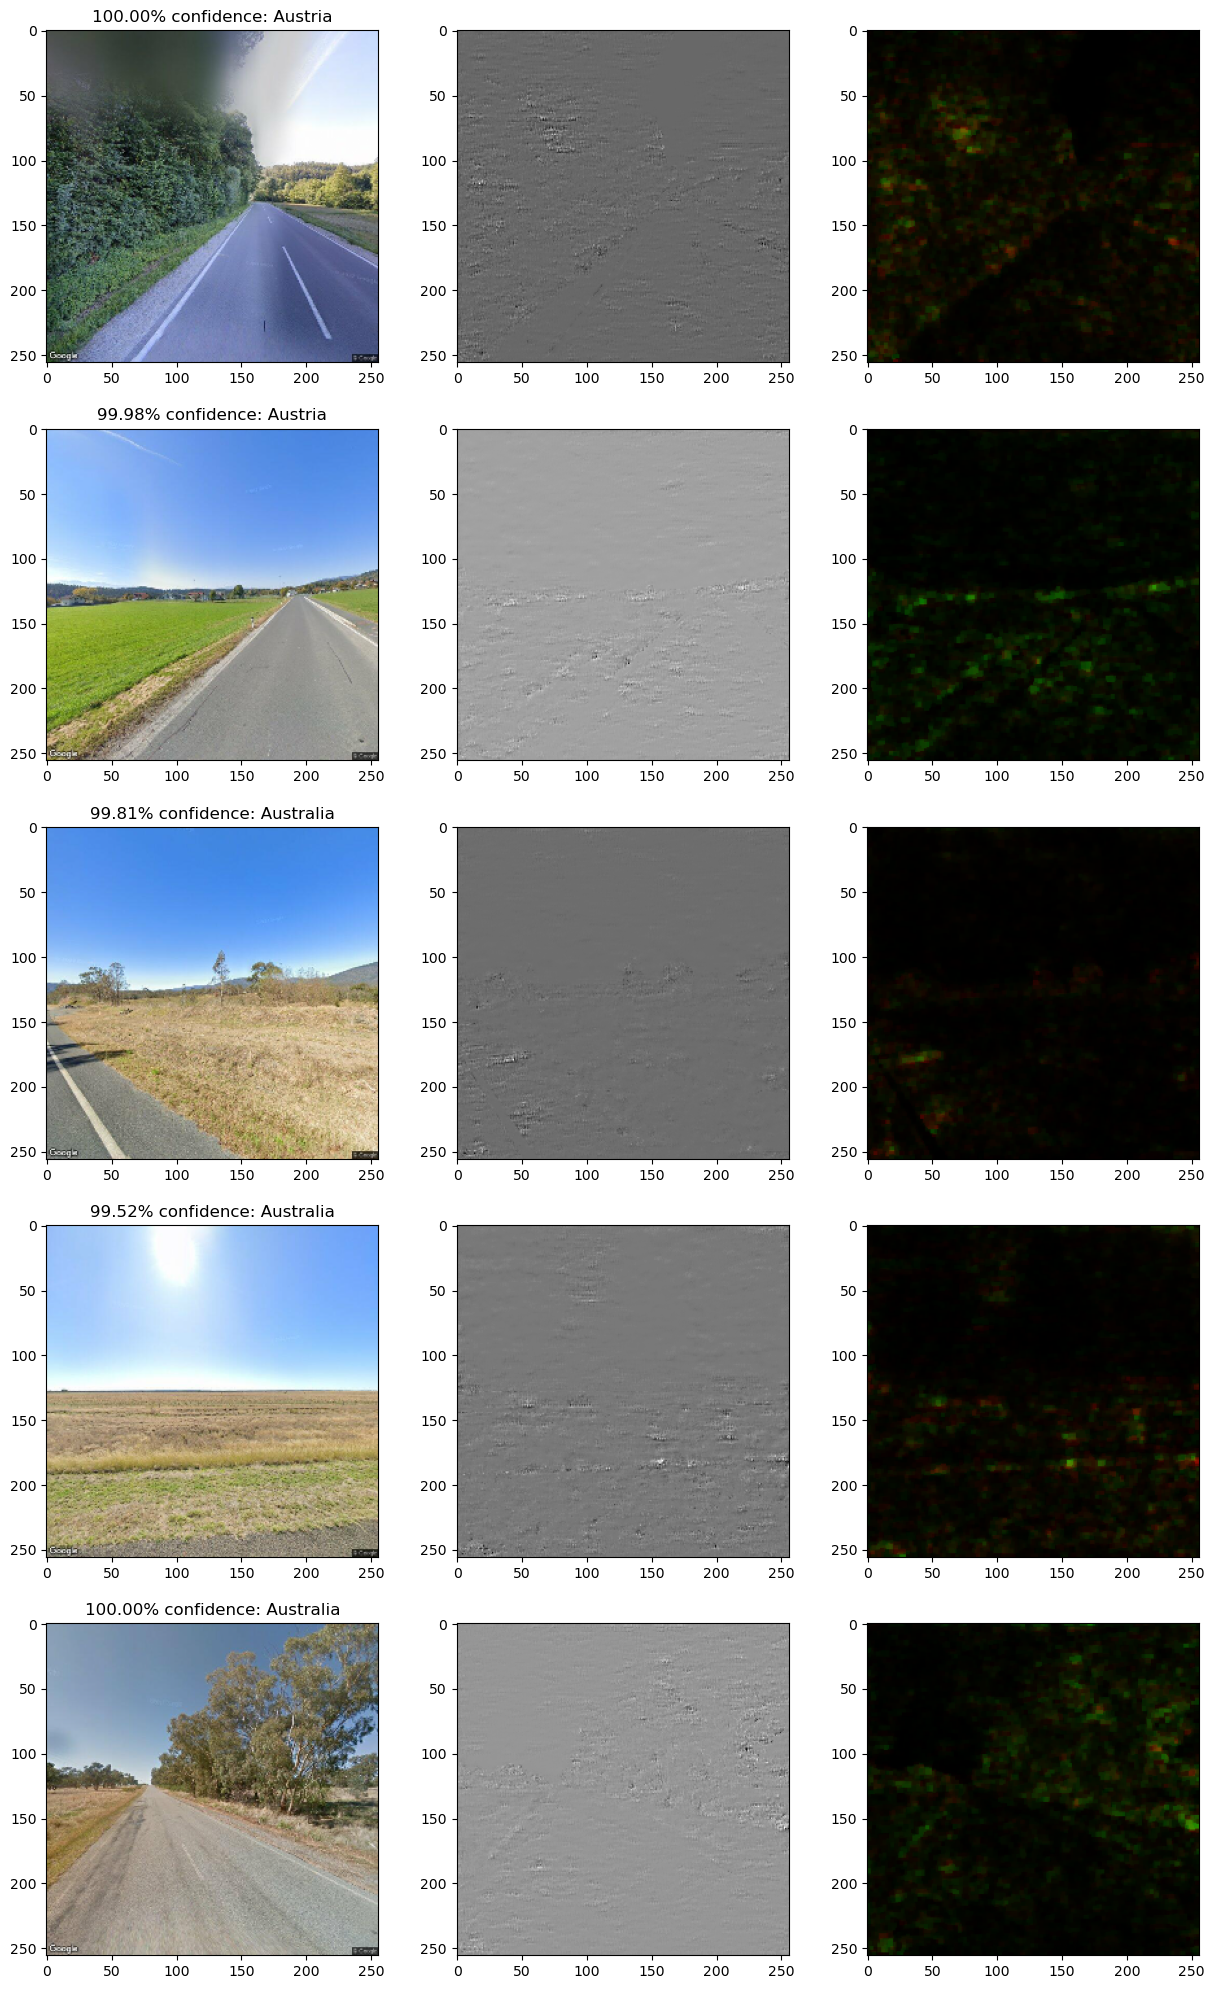

In [35]:
from visualization_lib import Visualize, pil_image, show_pil_image

num_images = 5
plt.figure(figsize= (15,5*num_images))
for images, labels in val_ds.take(1):
    print(attributions.shape)
    for i in range(num_images):
        aggregated_attributions = np.average(attributions[i], axis=2)
        
        visual_attributions = Visualize(attributions[i], images[i], polarity = "both", overlay = False, morphological_cleanup=True)
        print(np.sum(attributions[i]))
        print(predictions[i], labels[i])
        plt.subplot(num_images,3,3*i+1)
        
        plot_standardized_image(images[i], predictions[i])
        plt.subplot(num_images,3,3*i+2)
        plot_standardized_image(aggregated_attributions)
        plt.subplot(num_images,3,3*i+3)
        print(visual_attributions.shape)
        plt.imshow(np.uint8(visual_attributions))
        

-0.732788


NameError: name 'predictions' is not defined

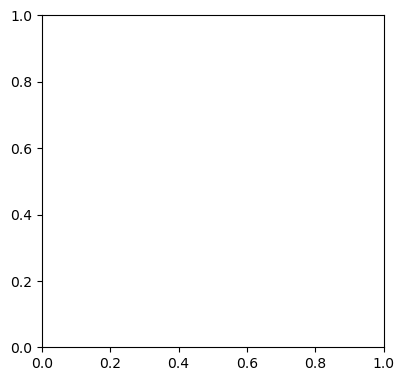

In [5]:
num_images = 5
plt.figure(figsize= (15,5*num_images))
aggregated_attributions = tf.reduce_sum(tf.math.abs(attributions), axis = -1)
for i in range(num_images):
    print(np.sum(attributions[i]))
    plt.subplot(num_images,3,3*i+1)
    print(predictions[i])
    plot_standardized_image(images[i], predictions[i])
    plt.subplot(num_images,3,3*i+2)
    plot_standardized_image(aggregated_attributions[i])
    plt.subplot(num_images,3,3*i+3)
    plot_standardized_image(tf.repeat(tf.expand_dims(aggregated_attributions[i], axis = 2), repeats = 3, axis = 2)*images[i])